# Estimate a probability with FORM

In this basic example we are going to estimate a failure probability.

Let's consider the following analytical example of a cantilever beam, of Young's modulus E, length L, section modulus I.

One end is built in a wall and we apply a concentrated bending load F at the other end of the beam, resulting in a deviation:
$$d = \frac{F*L^3}{3*E*I}$$

It is considered that failure occurs when the beam deviation is too important:

$$d \ge 30 (cm) $$

Four independent random variables are considered:

 - E (the Young's modulus) [Pa]
 - F (the load) [N]
 - L (the length) # [m]
 - I (the section) # [m^4]

Stochastic model (simplified model, no units):

 - E ~ Beta(0.93, 3.2, 2.8e7, 4.8e7)
 - F ~ LogNormal(30000, 9000, 15000)
 - L ~ Uniform(250, 260)
 - I ~ Beta(2.5, 4.0, 3.1e2, 4.5e2)


In [20]:
from __future__ import print_function
import openturns as ot

In [21]:
# Create the marginal distributions of the parameters
dist_E = ot.Beta(0.93, 3.2, 2.8e7, 4.8e7)
dist_F = ot.LogNormalMuSigma(30000, 9000, 15000).getDistribution()
dist_L = ot.Uniform(250, 260)
dist_I = ot.Beta(2.5, 4.0, 3.1e2, 4.5e2)
marginals = [dist_E, dist_F, dist_L, dist_I]

In [22]:
# Create the Copula
RS = ot.CorrelationMatrix(4)
RS[2, 3] = -0.2
# Evaluate the correlation matrix of the Normal copula from RS
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(RS)
# Create the Normal copula parametrized by R
copula = ot.NormalCopula(R) 

In [23]:
# Create the joint probability distribution
distribution = ot.ComposedDistribution(marginals, copula)
distribution.setDescription(['E', 'F', 'L', 'I'])

In [24]:
# create the model
model = ot.SymbolicFunction(['E', 'F', 'L', 'I'], ['F*L^3/(3*E*I)'])

In [25]:
# create the event we want to estimate the probability
vect = ot.RandomVector(distribution)
G = ot.CompositeRandomVector(model, vect)
event = ot.Event(G, ot.Greater(), 30.0)

In [26]:
# Define a solver
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumIterationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

In [27]:
# Run FORM
algo = ot.FORM(optimAlgo, event, distribution.getMean())
algo.run()
result = algo.getResult()
standardSpaceDesignPoint = result.getStandardSpaceDesignPoint()

In [28]:
# retrieve results
result = algo.getResult()
probability = result.getEventProbability()
print('Pf=', probability)

Pf= 0.00670980426490075


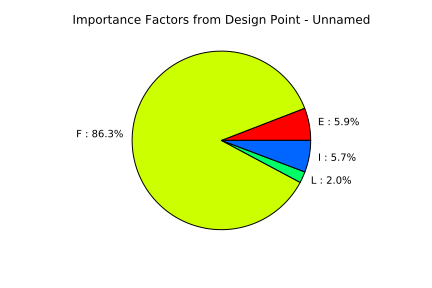

In [29]:
# Importance factors
result.drawImportanceFactors()